# Ejemplo de aplicación de test Post-Hoc de Friedman para anking de clasificadores

### Adrián Arnaiz Rodríguez

- Demšar, J. (2006). Statistical comparisons of classifiers over multiple data sets. Journal of Machine learning research, 7, 1-30.
    - https://edisciplinas.usp.br/pluginfile.php/4129451/mod_resource/content/1/model_selection_evaluation.pdf
    - https://www.tel.uva.es/descargar.htm;jsessionid=FD00403B76F542BEC4582B82FDF7E8AD?id=21795
    
- Salvador Garcia and Francisco Herrera. An extension on “statistical comparisons of classifiers over multiple data sets” for all pairwise comparisons. Journal of Machine Learning Research, 9:2677–2694, December 2008.
    - https://sci2s.ugr.es/sites/default/files/ficherosPublicaciones/1307_2010-Garcia-TAMIDA.pdf
    
    
#### 1. Test de Friedman sobre AUCs y Rankings a 'mano' (solo scipy)
#### 2. Test de Borf-Dunn a mano 1 vs all
#### 3. Creacion funciones
#### 4. Otras librerías: scikit_posthoc y Autorank



 # Posibles pipelines
 1. Friedman (scipy y a mano) + Nemanyi (scikit-posthoc): All vs All
 2. **Friedman (scipy y a mano) + Bonferoni-Hochberg Correction (mano): 1 vs All**
 3. Otros test de igualdad de medias y diferencias concretas segñun datos: AutoRank: All vs All

In [1]:
import scipy.stats as stats
import pandas as pd
import numpy as np

**Leemos los resultados de un anterior experimento**

In [27]:
resultados = pd.read_csv('res_auc_embbedings_norm_clf.csv')
resultados

,Datasets,KNN8,Tree,Bayes,SVM,RandomF,Ada,Reglas,GBC,MLP100,MLP10
0,RT_Embedding,0.832000,0.590000,0.642000,0.792000,0.750000,0.620000,0.430000,0.704000,0.864000,0.888000
1,A_Embedding,0.740975,0.587619,0.752596,0.723646,0.781323,0.794465,0.496667,0.811433,0.792358,0.811039
2,E_Embedding,0.687884,0.567857,0.625180,0.684975,0.655927,0.707916,0.555714,0.736542,0.750295,0.752932
3,I_Embedding,0.748180,0.578956,0.674691,0.704053,0.686239,0.547093,0.483590,0.646677,0.713111,0.727734
4,O_Embedding,0.640557,0.553800,0.608481,0.647351,0.644576,0.639483,0.492857,0.682911,0.637884,0.671548
5,U_Embedding,0.663141,0.588462,0.643319,0.647880,0.638609,0.659418,0.496474,0.754882,0.691371,0.673176


**Obtenemos los nombres de los algoritmos y el rendimiento de los clasificadores en un array numpy.**

In [28]:
clasificadores = resultados.drop('Datasets', axis=1).columns
clasificadores

Index(['KNN8', 'Tree', 'Bayes', 'SVM', 'RandomF', 'Ada', 'Reglas', 'GBC',
       'MLP100', 'MLP10'],
      dtype='object')

In [29]:
resultados_np = resultados[clasificadores].values
resultados_np.shape

(6, 10)

# POST-HOC

## 1. Aplicamos el test de friedman general sobre el rendimiento

Test no paramétrico equivalente de comparación de medias.

Le pasamos diferentes arrays de resultados, como cada array tiene que ser los resultados de un clasificador en diferentes datasets, le pasamos la matriz de resultados transpuesta.

In [307]:
stats.friedmanchisquare(*resultados_np.transpose())
#stats.friedmanchisquare(*resultados_np.transpose())
#NO SE SI HAY QUE TRANSPONERLO O NO, CREO QUE SÍ

FriedmanchisquareResult(statistic=38.76363636363635, pvalue=1.2707706250878477e-05)

* Vemos como hay una diferencia de medias, ya que tenemos un p-valor por debajo del nivel de significancia.

## Ahora, tenemos que comparar los clasificadores a través de los rankings

* Friedmann: diferencia general de rankings

En caso de que sean diferentes, ver entre cuales son diferentes:

* **Friedman: diferencia entre todos**
* **Nemenyi: diferencia concreta entre ellos**
* **Bonferroni-Dunn**

**Primero de todo establecemos un ranking de los clasificadores para cada dataset**

In [31]:
ranks = np.array([stats.rankdata(-p) for p in resultados_np])
ranks

array([[ 3.,  9.,  7.,  4.,  5.,  8., 10.,  6.,  2.,  1.],
       [ 7.,  9.,  6.,  8.,  5.,  3., 10.,  1.,  4.,  2.],
       [ 5.,  9.,  8.,  6.,  7.,  4., 10.,  3.,  2.,  1.],
       [ 1.,  8.,  6.,  4.,  5.,  9., 10.,  7.,  3.,  2.],
       [ 5.,  9.,  8.,  3.,  4.,  6., 10.,  1.,  7.,  2.],
       [ 4.,  9.,  7.,  6.,  8.,  5., 10.,  1.,  2.,  3.]])

Calculamos el ranking medio de cada clasificador

In [32]:
average_ranks = np.mean(ranks, axis=0)
dict_clf_avg_rank = {a:r for a, r in zip(clasificadores, average_ranks.round(2))}
for k in sorted(dict_clf_avg_rank, key=dict_clf_avg_rank.get):
    print(k,' ranking medio:\t', dict_clf_avg_rank[k])
    
#print('\n'.join('{} ranking medio:\t {}'.format(a, r) for a, r in zip(clasificadores, average_ranks.round(2))))

MLP10  ranking medio:	 1.83
GBC  ranking medio:	 3.17
MLP100  ranking medio:	 3.33
KNN8  ranking medio:	 4.17
SVM  ranking medio:	 5.17
RandomF  ranking medio:	 5.67
Ada  ranking medio:	 5.83
Bayes  ranking medio:	 7.0
Tree  ranking medio:	 8.83
Reglas  ranking medio:	 10.0


### Comparacion Rankings Firedman

El test de Friedman prueba si los rankings medios obtenidos son significativamente diferentes de el ranking medio esperado bajo la hipótesis nula  $R_j = \frac{\sum_i^{k} i}{k}$ siendo $k$ el número de clasificadores diferentes. $R_j$ es el ranking medio. **Bajo la hipótesis nula que indica que todos los algoritmos se comportan similarmente, por lo que sus rankings Rj deben ser iguales**

$$\chi^2_F = \frac{12n}{k(k + 1)} \left[\sum_k R_k^2 − \frac{k(k + 1)^2}{4}\right]$$

**Iman y Davenport** mostraron que el estadístico de Friedman presenta un comportamiento conservativo y propusieron un estadístico mejor.

$$F_F = \frac{(n-1)\chi^2_F}{n(k-1)\chi^2_F}$$ con $k − 1$ y $(k − 1)(n − 1)$ grados de libertad.


In [213]:
def friedman_ranking_chi(d, k, r, iman_davenport = False):
    '''
    d: numero de datasets
    k: numero de clasificadores
    r: np.array de rankings medios
    iman_davenport: devolver estadístico con corrección o normal
    '''
    first = (12*d) / (k*(k+1))
    sumat = np.sum(r**2)
    second = (k*((k+1)**2)) / 4
    res = first*(sumat-second)
    
    if iman_davenport:
        res = ((d-1)*res)/(d*(k-1)-res)
        print('Friedman IVAN-Davenport Chi Square - Datasets: {} - Clasificadores {}'.format(d,k))
        print('-- Chi_sq^2_f = {:.3f}'.format(res))
        
    else:
        print('Friedman Chi Square - Datasets: {} - Clasificadores {}'.format(d,k))
        print('-- Chi_sq^2_f = {:.3f}'.format(res))
        
    return res

**Ejemplo con datos de [Salvador García, Joaquín Derrac, Francisco Herrera, 2010](https://sci2s.ugr.es/sites/default/files/ficherosPublicaciones/1307_2010-Garcia-TAMIDA.pdf),** (para ver si he realizado bien los métodos). $F_f = 6.691$ y $F(3, 69) = 4,97e−4$

In [97]:
n_algs = 4
n_conj_datos = 24
rank_medios = np.array([1.771, 2.479, 2.479, 3.271])

In [98]:
Ff = friedman_ranking_chi(n_conj_datos,
                          n_algs,
                          rank_medios,
                          True)

Friedman IVAN-Davenport Chi Square - Datasets: 24 - Clasificadores 4
-- Chi_sq^2_f = 6.691


In [99]:
df1 = n_algs-1
df2 = (n_algs-1)*(n_conj_datos-1)
print('F({}, {}, {})'.format(Ff, df1, df2))
round(stats.f.sf(Ff, df1, df2),6)

F(6.690935434866362, 3, 69)


0.000497

* **Se rechaza la hipótesis nula de igualdad de rankings con alta probabilidad**


* ***La Tesis de Jose hace el ejemplo de (Demšar, J. (2006). Statistical comparisons of classifiers over multiple data sets. Journal of Machine learning research, 7, 1-30.) cuyo [código concreto está en este pdf].(https://edisciplinas.usp.br/pluginfile.php/4129451/mod_resource/content/1/model_selection_evaluation.pdf)***

In [100]:
n_algs = 4
n_conj_datos = 14
rank_medios = np.array([3.1432,2.0002,2.8932,1.9642])
Ff = friedman_ranking_chi(n_conj_datos,
                          n_algs,
                          rank_medios,
                          True)

df1 = n_algs-1
df2 = (n_algs-1)*(n_conj_datos-1)

print('F({}, {}, {})'.format(Ff, df1, df2))
round(stats.f.sf(Ff, df1, df2),6)

Friedman IVAN-Davenport Chi Square - Datasets: 14 - Clasificadores 4
-- Chi_sq^2_f = 3.706
F(3.7060507958937423, 3, 39)


0.019404

**Ejemplo con nuestro dataset**

In [38]:
n_datasets = resultados_np.shape[0]
n_clasificadores = resultados_np.shape[1]

estadChif = friedman_ranking_chi(n_datasets,
                             n_clasificadores,
                             average_ranks)

Friedman Chi Square - Datasets: 6 - Clasificadores 10
-- Chi_sq^2_f = 38.764


In [39]:
estadFf = friedman_ranking_chi(resultados_np.shape[0],
                             resultados_np.shape[1],
                             average_ranks,
                             True)

Friedman IVAN-Davenport Chi Square - Datasets: 6 - Clasificadores 10
-- Chi_sq^2_f = 12.721


In [40]:
# Obtenemos el p-valor de nuestro estadístico con los grados de libertad
stats.f.sf(estadFf, n_datasets, n_clasificadores)

0.0003576936965457399

* **Rechazamos la hipótesis nula de igualdad de Rankings**

# ¿Se realizaría Bonferroni-Dunn’s (1 vs all) o Nemanyi (all vs all) para comparar las diferencias ? 

### 2. Bonferoni-Holm Correction: 1 vs All

* https://github.com/ben-ix/MethodComparisonsInPython/blob/master/StatisticalTests.ipynb
* https://github.com/ben-ix/MethodComparisonsInPython/blob/master/stac/nonparametric_tests.py

**Función y ejemplo de  Demšar, J. (2006).**

In [362]:
def hochberg_test(ranks, n_datasets, control=None, alpha=0.05):
    """
        Parameters
        ----------
        ranks : dictionary
            A dictionary with format 'Classifier':'mean_rank' 
        control : string optional
            The name of the control method (one vs all), if None: best is choosen
            
        Returns
        ----------
        Comparions : np.array-like
            Strings identifier of each comparison with format 'group_i_control vs group_j'
            
        Z-values : np.array-like
            The computed Z-value statistic for each comparison.
            
        p-values : np.array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
            
        adj_sigmas : np.array-like
            The associated adjusted sigma according HOCHBERG test alpha/i, being i the reverse of the position in ranking.
            
        References
        ----------
        Demšar, J. (2006). Statistical comparisons of classifiers over multiple data sets. Journal of Machine learning research, 7(Jan), 1-30.
    """
    k = len(ranks) # numero de tests
    values = list(ranks.values())
    keys = list(ranks.keys())

    control_i = values.index(min(values)) if not control else keys.index(control)

    # Strings de comparaciones
    comparisons = [keys[control_i] + " vs " + keys[i] for i in range(k) if i != control_i]
    
    # Estadísticos y pval
    # Estadisticos son la diferencia de rankings medios
    # Error estandar según Demsar
    se = np.sqrt((k*(k+1))/(6*n_datasets)) 

    z_values = [abs(values[control_i] - values[i])/se for i in range(k) if i != control_i]
    p_values = [2*(1-stats.norm.cdf(abs(z))) for z in z_values]
    
    # Ordenarmos por pval
    p_values, z_values, comparisons = map(list, zip(*sorted(zip(p_values, z_values, comparisons), key=lambda t: t[0])))
    
    # Ajustamos sigma según Hochner
    adj_sigmas = [alpha/i for i in range(k-1,0,-1)]
    
    return np.asarray(comparisons), np.asarray(z_values), np.asarray(p_values), np.asarray(adj_sigmas)



,z,p,alpha/i,sig
C4.5 vs C4.5+m+cf,2.416,0.016,0.017,True
C4.5 vs C4.5+m,2.342,0.019,0.025,True
C4.5 vs C4.5+cf,0.512,0.608,0.050,False


In [205]:
comparisons, z_values, p_values, adj_sigmas = hochberg_test({'C4.5':3.143,
                                                           'C4.5+m': 2.000,
                                                           'C4.5+cf':2.893,
                                                           'C4.5+m+cf':1.964},
                                                        n_datasets = 14,
                                                        control='C4.5',
                                                        alpha=0.05)

holm_scores = pd.DataFrame({"z":z_values.round(3),"p": p_values.round(3),
                            'alpha/i':adj_sigmas.round(3) ,"sig": p_values < adj_sigmas}, 
                           index=comparisons)
holm_scores

,z,p,alpha/i,sig
C4.5 vs C4.5+m+cf,2.416,0.016,0.017,True
C4.5 vs C4.5+m,2.342,0.019,0.025,True
C4.5 vs C4.5+cf,0.512,0.608,0.050,False


 * Perfecto, mismo resultado que en Demšar, J. (2006).

### Ejemplo tabla 4.13 Tesis Jose ### OJO QUE NO DA LO MISMO, sobre todo davenport
*Table 4.13 shows the average ranking of the **62 data sets** shown in Table
4.2, at different noise levels (the ranking was given by the ordering of the
methods according to their accuracy). **The Iman-Davenport test gives pvalues
of 4.956e-2, 1.786e-5 and 3.082e-8**, which means that it rejects the
hypothesis of the equivalence of the algorithms under comparison. Taking
Random Forest as the reference method, a **post-hoc Hochberg test was also
performed**. The methods that were significantly different from Random Forest, according to the Hochberg test, at a confidence level of 0.05, appear
above the horizontal line. In the case of data sets without the added noise,
although the G-Forest is not significantly better than random forest, its
improvement, GAR-Forest, increases the difference and makes it significant.
With noisy data sets, both methods are significantly better than Random
Forest. The actual scores are shown in tables 5.7, 4.11 and 4.12, where the
wins, draws and losses are also shown at the bottom of the table, the second
line shows the statistical significant results, according to the Student’s ttest
for a = 0:05 (the corrected version suggested in [46], the default in
Weka). The significant victories and losses are also marked in the tables
with Xand * respectively. Table 5.7 shows the results for the original data
sets. Tables 4.11 and 4.12 show the results for the datasets with 10% and
20% class noise.*

*No noise*

In [192]:
n_datasets_jose = 62
rankings = {'GAR-F':1.758,'G-F': 2.056,'R F': 2.185}

estadFf = friedman_ranking_chi(n_datasets_jose, #numero datasets
                               len(rankings), #numero de clfs
                               np.asarray(list(rankings.values())), 
                               iman_davenport=True)

df1 = len(rankings)-1
df2 = (len(rankings)-1)*(n_datasets_jose-1)

print('F({}, {}, {})'.format(Ff, df1, df2))
pval_Ivan_Dav = stats.f.sf(estadFf, df1, df2)
print(f'p-value IVAN DAVENPORT: {pval_Ivan_Dav:.5f}')

Friedman IVAN-Davenport Chi Square - Datasets: 62 - Clasificadores 3
-- Chi_sq^2_f = 2.939
F(3.7060507958937423, 2, 122)
p-value IVAN DAVENPORT: 0.05669


In [298]:
comparisons, z_values, p_values, adj_sigmas = holm_test(rankings,
                                                        n_datasets=n_datasets_jose,
                                                        control='R F',
                                                        alpha=0.05)
p_values = np.asarray(p_values)
adj_sigmas = np.asarray(adj_sigmas)
holm_scores = pd.DataFrame({"z":z_values,"p-Hoch": p_values, 'alpha/i':adj_sigmas ,"sig": p_values < adj_sigmas}, index=comparisons)
holm_scores

0.1796053020267749


,z,p-Hoch,alpha/i,sig
R F vs GAR-F,2.377435,0.017433,0.025,True
R F vs G-F,0.718242,0.472608,0.050,False


*10% noise*

In [352]:
rankings = {'GAR-F':1.766, 'G-F': 1.766, 'R F': 2.468}

estadFf = friedman_ranking_chi(n_datasets_jose, #numero datasets
                               len(rankings), #numero de rankings
                               np.asarray(list(rankings.values())), 
                               iman_davenport=True)

# Obtenemos el p-valor de nuestro estadístico con los grados de libertad
pval_Ivan_Dav = stats.f.sf(estadFf, n_datasets_jose, len(rankings))
print(f'p-value IVAN DAVENPORT: {pval_Ivan_Dav:.5f}')

Friedman IVAN-Davenport Chi Square - Datasets: 62 - Clasificadores 3
-- Chi_sq^2_f = 11.990
p-value IVAN DAVENPORT: 0.03116


In [300]:
comparisons, z_values, p_values, adj_sigmas = holm_test(rankings,
                                                        n_datasets=62,
                                                        control='R F',
                                                        alpha=0.05)
p_values = np.asarray(p_values)
adj_sigmas = np.asarray(adj_sigmas)
holm_scores = pd.DataFrame({"z":z_values,"p-Hoch": p_values, 'alpha/i':adj_sigmas ,"sig": p_values < adj_sigmas}, index=comparisons)
holm_scores

0.1796053020267749


,z,p-Hoch,alpha/i,sig
R F vs GAR-F,3.908571,0.000093,0.025,True
R F vs G-F,3.908571,0.000093,0.050,True


*20% noise*

In [301]:
rankings = {'GAR-F':1.806, 'G-F': 1.629, 'R F': 2.565}

estadFf = friedman_ranking_chi(n_datasets_jose, #numero datasets
                               len(rankings), #numero de rankings
                               np.asarray(list(rankings.values())), 
                               iman_davenport=True)

# Obtenemos el p-valor de nuestro estadístico con los grados de libertad
pval_Ivan_Dav = stats.f.sf(estadFf, n_datasets_jose, len(rankings))
print(f'p-value IVAN DAVENPORT: {pval_Ivan_Dav:.5f}')

Friedman IVAN-Davenport Chi Square - Datasets: 62 - Clasificadores 3
-- Chi_sq^2_f = 20.036
p-value IVAN DAVENPORT: 0.01488


In [302]:
comparisons, z_values, p_values, adj_sigmas = holm_test(rankings,
                                                        n_datasets=n_datasets_jose,
                                                        control='R F',
                                                        alpha=0.05)
p_values = np.asarray(p_values)
adj_sigmas = np.asarray(adj_sigmas)
holm_scores = pd.DataFrame({"z":z_values,"p-Hoch": p_values, 'alpha/i':adj_sigmas ,"sig": p_values < adj_sigmas}, index=comparisons)
holm_scores

0.1796053020267749


,z,p-Hoch,alpha/i,sig
R F vs G-F,5.211427,1.873931e-07,0.025,True
R F vs GAR-F,4.225933,2.379526e-05,0.050,True


## 3. Metodo personalizado

In [7]:
import post_hoc as ph

In [11]:
resultados = pd.read_csv('4_10_table_JOSE.csv')
resultados.head(2)

,Dataset,Random Forest,G-Forest,GAR-Forest
0,abalone,24.42,25.02,24.81
1,anneal,99.15,98.84,98.64


In [12]:
ph.posthoc_Friedman_Davenport_Hochbertest(resultados, control='Random Forest')

### Experimento
# Number of classifiers: 3
# Number of datasets: 62
# Name of classifiers: Random Forest, G-Forest, GAR-Forest
# Alpha: 0.05

### Métricas
# Test de Friedman sobre métricas 
	-> p-val: 0.0346

### Rankings
# GAR-Forest    ranking medio:  1.75
# G-Forest      ranking medio:  2.048
# Random Forest ranking medio:  2.202
# Test de Friedman sobre Rankings [F(6.5403, 2, 122)]               
	-> p-val: 0.0020

### Test Hochberg Comparacion Random Forest vs all
# Tabla de comparación de Rankings:
                                 z      p  alpha/i    sig
Random Forest vs GAR-Forest  2.517  0.012    0.025   True
Random Forest vs G-Forest    0.857  0.391    0.050  False


,z,p,alpha/i,sig
Random Forest vs GAR-Forest,2.517,0.012,0.025,True
Random Forest vs G-Forest,0.857,0.391,0.050,False


# 4. Otras librerias
### scikit_posthocs 

**ALL vs ALL**

*scikit-posthocs is a Python package which provides post hoc tests for pairwise multiple comparisons that are usually
performed in statistical data analysis to assess the differences between group levels if a statistically significant result
of ANOVA test has been obtained* (https://readthedocs.org/projects/scikit-posthocs/downloads/pdf/latest/)

In [44]:
import scikit_posthocs as sp

In [45]:
pvalsNemenyi = sp.posthoc_nemenyi_friedman(resultados_np)

In [78]:
rrr = pvalsNemenyi
rrr.columns = clasificadores
rrr.index = clasificadores
rrr

,KNN8,Tree,Bayes,SVM,RandomF,Ada,Reglas,GBC,MLP100,MLP10
KNN8,-1.000000,0.185814,0.818024,0.900000,0.900000,0.900000,0.029060,0.900000,0.900000,0.900000
Tree,0.185814,-1.000000,0.900000,0.524911,0.700778,0.759402,0.900000,0.039417,0.052706,0.002509
Bayes,0.818024,0.900000,-1.000000,0.900000,0.900000,0.900000,0.759402,0.464278,0.524911,0.090517
SVM,0.900000,0.524911,0.900000,-1.000000,0.900000,0.900000,0.148392,0.900000,0.900000,0.642156
RandomF,0.900000,0.700778,0.900000,0.900000,-1.000000,0.900000,0.279939,0.900000,0.900000,0.464278
Ada,0.900000,0.759402,0.900000,0.900000,0.900000,-1.000000,0.335805,0.876649,0.900000,0.399341
Reglas,0.029060,0.900000,0.759402,0.148392,0.279939,0.335805,-1.000000,0.003676,0.005336,0.001000
GBC,0.900000,0.039417,0.464278,0.900000,0.900000,0.876649,0.003676,-1.000000,0.900000,0.900000
MLP100,0.900000,0.052706,0.524911,0.900000,0.900000,0.900000,0.005336,0.900000,-1.000000,0.900000
MLP10,0.900000,0.002509,0.090517,0.642156,0.464278,0.399341,0.001000,0.900000,0.900000,-1.000000


(<matplotlib.axes._subplots.AxesSubplot at 0x1d3b82b56a0>,
 <matplotlib.colorbar.ColorbarBase at 0x1d3b8358ac8>)

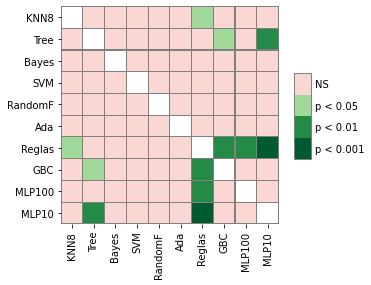

In [79]:
heatmap_args = {'linewidths': 0.1, 'linecolor': '0.5', 'clip_on': 0, 'square':True, 'cbar_ax_bbox': [0.8, 0.35, 0.04, 0.3]}
sp.sign_plot(pvalsNemenyi, labels=True, **heatmap_args)


### Autorank

**All vs ALL** con diferentes test según el dataset.

https://pypi.org/project/autorank/

https://github.com/sherbold/autorank

Elige las pruebas a realizar según las características de los datos. El diagrama de flujo de las pruebas que aplica están en suu github.

In [48]:
import matplotlib.pyplot as plt
from autorank import autorank, plot_stats, create_report, latex_table

In [49]:
result = autorank(resultados.drop('Datasets', axis=1), alpha=0.05, verbose=False)
print(result)

RankResult(rankdf=
          meanrank      mean        std  ci_lower  ci_upper effect_size  \
MLP10     1.833333  0.754071   0.083942  0.693931  0.814212           0   
GBC       3.166667  0.722741  0.0579882    0.6626  0.782882    0.434292   
MLP100    3.333333  0.741503  0.0796558  0.681362  0.801644    0.153596   
KNN8      4.166667   0.71879   0.069778  0.658649   0.77893    0.457106   
SVM       5.166667  0.699984  0.0543208  0.639843  0.760125    0.765025   
RandomF   5.666667  0.692779  0.0596205  0.632638   0.75292    0.841883   
Ada       5.833333  0.661396  0.0838264  0.601255  0.721537      1.1048   
Bayes     7.000000  0.657711  0.0514341   0.59757  0.717852     1.38424   
Tree      8.833333  0.577782  0.0143884  0.517641  0.637923     2.92734   
Reglas   10.000000   0.49255  0.0400373  0.432409  0.552691     3.97679   

          magnitude  
MLP10    negligible  
GBC           small  
MLP100   negligible  
KNN8          small  
SVM          medium  
RandomF       large  
A

In [50]:
create_report(result)

The statistical analysis was conducted for 10 populations with 6 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.187). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.123) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each population. Populations are significantly different if their confid

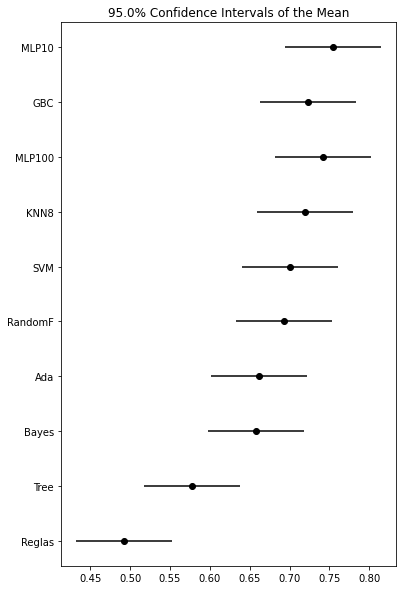

In [51]:
plot_stats(result)
plt.show()

In [52]:
latex_table(result)

\begin{table}[h]
\centering
\begin{tabular}{llllll}
\toprule
{} &     M &    SD &              CI &   \$d\$ &   Magnitude \\
\midrule
MLP10   & 0.754 & 0.084 &  [0.694, 0.814] & 0.000 &  negligible \\
GBC     & 0.723 & 0.058 &  [0.663, 0.783] & 0.434 &       small \\
MLP100  & 0.742 & 0.080 &  [0.681, 0.802] & 0.154 &  negligible \\
KNN8    & 0.719 & 0.070 &  [0.659, 0.779] & 0.457 &       small \\
SVM     & 0.700 & 0.054 &  [0.640, 0.760] & 0.765 &      medium \\
RandomF & 0.693 & 0.060 &  [0.633, 0.753] & 0.842 &       large \\
Ada     & 0.661 & 0.084 &  [0.601, 0.722] & 1.105 &       large \\
Bayes   & 0.658 & 0.051 &  [0.598, 0.718] & 1.384 &       large \\
Tree    & 0.578 & 0.014 &  [0.518, 0.638] & 2.927 &       large \\
Reglas  & 0.493 & 0.040 &  [0.432, 0.553] & 3.977 &       large \\
\bottomrule
\end{tabular}
\caption{Summary of populations}
\label{tbl:stat_results}
\end{table}


------------------------

## Ejemplo completo 4.10 Jose

**1. Carga de datos**

In [2]:
resultados = pd.read_csv('4_10_table_JOSE.csv')
resultados

,Dataset,Random Forest,G-Forest,GAR-Forest
0,abalone,24.42,25.02,24.81
1,anneal,99.15,98.84,98.64
2,audiology,74.78,76.19,76.55
3,autos,76.40,73.08,75.03
4,balance-scale,84.32,86.72,85.41
...,...,...,...,...
57,vowel-nocontext,92.00,91.96,92.22
58,waveform,84.89,85.81,85.38
59,yeast,59.62,60.66,60.84
60,zip,95.89,95.30,96.00


In [413]:
clasificadores = resultados.drop('Dataset', axis=1).columns
clasificadores

Index(['Random Forest', 'G-Forest', 'GAR-Forest'], dtype='object')

In [414]:
resultados_np = resultados[clasificadores].values
n_datasets = resultados_np.shape[0]
n_clasificadores = resultados_np.shape[1]
n_datasets, n_clasificadores, resultados_np.shape

(62, 3, (62, 3))

**2. Test de Friedman sobre AUCS**

In [415]:
print(stats.friedmanchisquare(*resultados_np),'\n ->',
stats.friedmanchisquare(*resultados_np.transpose()))

FriedmanchisquareResult(statistic=181.35526790735943, pvalue=7.076503507269009e-14) 
 -> FriedmanchisquareResult(statistic=6.730290456431497, pvalue=0.03455699710253077)


* **OJO**: A Jose le da diferente: 0.04956

**3. Test de Friedman sobre rankings**

In [416]:
ranks = np.array([stats.rankdata(-p) for p in resultados_np])
ranks.shape

(62, 3)

In [417]:
average_ranks = np.mean(ranks, axis=0)
dict_clf_avg_rank = {a:r for a, r in zip(clasificadores, average_ranks.round(3))}
for k in sorted(dict_clf_avg_rank, key=dict_clf_avg_rank.get):
    print(k,' ranking medio:\t', dict_clf_avg_rank[k])

GAR-Forest  ranking medio:	 1.75
G-Forest  ranking medio:	 2.048
Random Forest  ranking medio:	 2.202


In [418]:
eFf = friedman_ranking_chi(n_datasets, #numero datasets
                               n_clasificadores, #numero de clfs
                               average_ranks, 
                               iman_davenport=True)

df1 = n_clasificadores-1
df2 = (n_clasificadores-1)*(n_datasets-1)

print('F({}, {}, {})'.format(eFf, df1, df2))
pval_Ivan_Dav = stats.f.sf(eFf, df1, df2)
print(f'p-value IVAN DAVENPORT: {pval_Ivan_Dav:.5f}')

Friedman IVAN-Davenport Chi Square - Datasets: 62 - Clasificadores 3
-- Chi_sq^2_f = 3.397
F(3.396567112941949, 2, 122)
p-value IVAN DAVENPORT: 0.03669


* **OJO**: A Jose le da diferente: 0.04956

**4. Test de Hocher para comparación de 1vsALL**

In [421]:
comparisons, z_values, p_values, adj_sigmas = hochberg_test(dict_clf_avg_rank,
                                                        n_datasets = n_datasets,
                                                        control='Random Forest',
                                                        alpha=0.05)

holm_scores = pd.DataFrame({"z":z_values.round(3),"p": p_values.round(3),
                            'alpha/i':adj_sigmas.round(3) ,"sig": p_values < adj_sigmas}, 
                           index=comparisons)
holm_scores

,z,p,alpha/i,sig
Random Forest vs GAR-Forest,2.517,0.012,0.025,True
Random Forest vs G-Forest,0.857,0.391,0.050,False


### 3. Metodos personalizados

In [5]:
import post_hoc as ph

In [6]:
ph.posthoc_Friedman_Davenport_Hochbertest(resultados, control='Random Forest')

### Experimento
# Number of classifiers: 3
# Number of datasets: 62
# Name of classifiers: Random Forest, G-Forest, GAR-Forest
# Alpha: 0.05

### Métricas
# Test de Friedman sobre métricas 
	-> p-val: 0.0346

### Rankings
# GAR-Forest    ranking medio:  1.75
# G-Forest      ranking medio:  2.048
# Random Forest ranking medio:  2.202
# Test de Friedman sobre Rankings [F(6.5403, 2, 122)]               
	-> p-val: 0.0020

### Test Hochberg Comparacion Random Forest vs all
# Tabla de comparación de Rankings:
                                 z      p  alpha/i    sig
Random Forest vs GAR-Forest  2.517  0.012    0.025   True
Random Forest vs G-Forest    0.857  0.391    0.050  False


,z,p,alpha/i,sig
Random Forest vs GAR-Forest,2.517,0.012,0.025,True
Random Forest vs G-Forest,0.857,0.391,0.050,False


### Anexo: Clase post_hoc

```python

def friedman_ranking_chi(d, k, r, iman_davenport = False, verbose=True):
    '''
    d: numero de datasets
    k: numero de clasificadores
    r: np.array de rankings medios
    iman_davenport: devolver estadístico con corrección o normal
    '''
    first = (12*d) / (k*(k+1))
    sumat = np.sum(r**2)
    second = (k*((k+1)**2)) / 4
    res = first*(sumat-second)
    
    if iman_davenport and verbose:
        res = ((d-1)*res)/(d*(k-1)-res)
        print('Friedman IVAN-Davenport Chi Square - Datasets: {} - Clasificadores {}'.format(d,k))
        print('-- Chi_sq^2_f = {:.3f}'.format(res))
        
    elif verbose:
        print('Friedman Chi Square - Datasets: {} - Clasificadores {}'.format(d,k))
        print('-- Chi_sq^2_f = {:.3f}'.format(res))
        
    return res

def hochberg_test(ranks, n_datasets, control=None, alpha=0.05):
    """
        Parameters
        ----------
        ranks : dictionary
            A dictionary with format 'Classifier':'mean_rank' 
        control : string optional
            The name of the control method (one vs all) 
            
        Returns
        ----------
        Comparions : np.array-like
            Strings identifier of each comparison with format 'group_i_control vs group_j'
            
        Z-values : np.array-like
            The computed Z-value statistic for each comparison.
            
        p-values : np.array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
            
        adj_sigmas : np.array-like
            The associated adjusted sigma according HOCHBERG test alpha/i, being i the reverse of the position in ranking.
            
        References
        ----------
        Demšar, J. (2006). Statistical comparisons of classifiers over multiple data sets. Journal of Machine learning research, 7(Jan), 1-30.
    """
    k = len(ranks) # numero de tests
    values = list(ranks.values())
    keys = list(ranks.keys())

    control_i = values.index(min(values)) if not control else keys.index(control)

    # Strings de comparaciones
    comparisons = [keys[control_i] + " vs " + keys[i] for i in range(k) if i != control_i]
    
    # Estadísticos y pval
    # Estadisticos son la diferencia de rankings medios
    # Error estandar según Demsar
    se = np.sqrt((k*(k+1))/(6*n_datasets)) 

    z_values = [abs(values[control_i] - values[i])/se for i in range(k) if i != control_i]
    p_values = [2*(1-stats.norm.cdf(abs(z))) for z in z_values]
    #p_values = [2*(1-stats.norm.cdf(abs(z))) for z in z_values]
    
    # Ordenarmos por pval
    p_values, z_values, comparisons = map(list, zip(*sorted(zip(p_values, z_values, comparisons), key=lambda t: t[0])))
    
    # Ajustamos sigma según Hochner
    adj_sigmas = [alpha/i for i in range(k-1,0,-1)]
    
    return np.asarray(comparisons), np.asarray(z_values), np.asarray(p_values), np.asarray(adj_sigmas)

def posthoc_Friedman_Davenport_Hochbertest(results, alpha=0.05, obj='max', control=None, verbose=True):
    '''
    results: DataFrame like
        Each row a dataset, each column a classifiers. Column of datasets names calles 'Dataset'
    '''
    
    # Preparamos resultados en numpy, array de nombres y datos del experimento
    name_clfs = results.drop('Dataset', axis=1).columns
    results_np = results[name_clfs].values
    n_datasets = results_np.shape[0]
    n_clfs = results_np.shape[1]
    
    #1. Realizamos friedman sobre los resultados de evaluación
    stat_fried_metric, pval_fried_metric = stats.friedmanchisquare(*results_np.transpose())
    
    #2. Realizamos test de friedman sobre los rankings
    #Calculamos rankings y rankings medios en np y dict
    all_ranks = np.array([stats.rankdata(-p) for p in results_np]) if obj=='max' else np.array([stats.rankdata(p) for p in results_np])
    average_ranks = np.mean(all_ranks, axis=0)
    dict_clf_avg_rank = {c:r for c, r in zip(name_clfs, average_ranks.round(3))}
    #Calculamos el estadistico de Iman-Davenport
    stat_ImanDaven_ranks = friedman_ranking_chi(n_datasets, #numero datasets
                                                n_clfs, #numero de clfs
                                                average_ranks, 
                                                iman_davenport=True,
                                                verbose= False)
    df1 = n_clfs-1
    df2 = (n_clfs-1)*(n_datasets-1)
    pval_ImanDaven_ranks = stats.f.sf(stat_ImanDaven_ranks, df1, df2)
    
    #3. Test de Hochberg
    comparisons_h, z_values_h, p_values_h, adj_sigmas_h = hochberg_test(dict_clf_avg_rank,
                                                        n_datasets = n_datasets,
                                                        control=control,
                                                        alpha=alpha)

    holm_scores = pd.DataFrame({"z":z_values_h.round(3),"p": p_values_h.round(3),
                                'alpha/i':adj_sigmas_h.round(3) ,"sig": p_values_h < adj_sigmas_h}, 
                               index=comparisons_h)

    if verbose:
        print(f'### Experimento')
        print(f'# Number of classifiers: {n_clfs}')
        print(f'# Number of datasets: {n_datasets}')
        print('# Name of classifiers: {}'.format(', '.join(name_clfs.format())))
        print(f'# Alpha: {alpha}')
        
        print(f'\n### Métricas')
        print(f'# Test de Friedman sobre métricas \n\t-> p-val: {pval_fried_metric:.4f}')
        
        print(f'\n### Rankings')
        mx_string = len(max(name_clfs, key=lambda x: len(x)))
        for k in sorted(dict_clf_avg_rank, key=dict_clf_avg_rank.get):
            print('# {:{}} ranking medio:  {}'.format(k,mx_string,dict_clf_avg_rank[k]))
        print(f'# Test de Friedman sobre Rankings [F({stat_ImanDaven_ranks:.4f}, {df1}, {df2})] \
              \n\t-> p-val: {pval_ImanDaven_ranks:.4f}')
        one = min(dict_clf_avg_rank, key=dict_clf_avg_rank.get) if control is None else control
        print('\n### Test Hochberg Comparacion {} vs all'.format(one))
        print('# Tabla de comparación de Rankings:')
        print(holm_scores)
    
    return holm_scores
```